In [1]:
import pandas as pd
from pyathena import connect
from pyathena.pandas.cursor import PandasCursor
import os
import boto3
import time
import re
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from matplotlib.colors import to_hex
from matplotlib.lines import Line2D
import rpy2
%load_ext rpy2.ipython
import seaborn as sns
STAGING_BUCKET = os.environ['STAGING_BUCKET']
ATHENA_CURSOR = connect(s3_staging_dir=STAGING_BUCKET,
                 region_name="us-west-2",
                 cursor_class=PandasCursor).cursor()

In [2]:
s3 = boto3.client('s3')

In [3]:
def get_file_sizes():
    pf = 'NovaSeq/Microbioal-Isolation/220617_A00585_0485_AHLJFTDSX3_AgBiome_Run171/AgBiome_220617_Run171_Assembly'
    buck = 'agbiome-mogene-data-transfer'
    keys = []
    sizes = []
    response = s3.list_objects_v2(
        Bucket=buck,
        MaxKeys=1000,
        Prefix=pf
    )
    cont_token = response['NextContinuationToken']
    print(cont_token)
    for k in response['Contents']:
        if re.search(r"AgBiome_AIM[0-9]{6}_[0-9]*_[A-H][0-9]{1,2}_[0-9]{6}_consensus\.fasta", k['Key']):
            keys.append(k['Key'])
            sizes.append(k['Size'])
        else:
            pass
    
    while "NextContinuationToken" in response:
        response = s3.list_objects_v2(
            Bucket=buck,
            MaxKeys=1000,
            Prefix=pf,
            ContinuationToken=cont_token
            )
        for k in response['Contents']:
            if re.search(r"AgBiome_AIM[0-9]{6}_[0-9]*_[A-H][0-9]{1,2}_[0-9]{6}_consensus\.fasta", k['Key']):
                keys.append(k['Key'])
                sizes.append(k['Size'])
            else:
                pass
        if 'NextContinuationToken' in response:
            cont_token = response['NextContinuationToken']
        else:
            pass
    print("Finished gathering keys...")
    return({'files': keys,'file_size': sizes})

In [4]:
get_sizes = get_file_sizes()

1dCECeC9E56VCGfJreqH4nclP4QSq/+v+ApobGEOkJcAw6f5aa2n4frX68ptLTdm7TEyN9ti9A5CcHfMsTJ5K563RYZkUpxWlwVxH4gacRyv1ivz1W3I7+47yDrqXkUYlFzeIse0goDY5gE1y2pE+0tAZeUKiHhzQQHeeKihCoCDHflGwIPlcxVcUEoVUL/jv3CJof/BL3vieVv8ddXMCAhaOE5rflmtx+/qt/hIbpn5YvbG1ak2BoMejC2w/l2Raz0uy08AAfMNC5FYnc2KUYAyUCSYjTY5HaXMTDMCuF1K7E88b0M0377aEE7BU75Q7cwAcAm6vfz4=
Finished gathering keys...


In [5]:
df = pd.DataFrame(get_sizes)

In [6]:
df.head()

,files,file_size
0,NovaSeq/Microbioal-Isolation/220617_A00585_048...,504923
1,NovaSeq/Microbioal-Isolation/220617_A00585_048...,17670644
2,NovaSeq/Microbioal-Isolation/220617_A00585_048...,113136
3,NovaSeq/Microbioal-Isolation/220617_A00585_048...,13403044
4,NovaSeq/Microbioal-Isolation/220617_A00585_048...,106775


In [7]:
df.to_csv('../data/filenames_and_sizes.csv', index=False)

In [69]:
def extract_aim(identifier):
    return int(re.search('AIM(\d+)', identifier).group(1))

In [70]:
df['aim'] = df['files'].apply(extract_aim)

In [105]:
df.files[200]

'NovaSeq/Microbioal-Isolation/220617_A00585_0485_AHLJFTDSX3_AgBiome_Run171/AgBiome_220617_Run171_Assembly/220617_Run171_Plate1009/AIM108598_1009_A5_Assembly/AgBiome_AIM108598_1009_A5_220617_consensus.fasta'

In [106]:
q = f"""
    SELECT aim,
            date,
            plate,
            asm,
            completeness,
            contamination
    FROM genomics.checkm_o2_csv
    WHERE aim IN {tuple(df.aim.unique())}
    AND date > '2022-06-01'
    """
aws_qc = ATHENA_CURSOR.execute(q).as_pandas()

In [107]:
aws_qc.head()

,aim,date,plate,asm,completeness,contamination
0,6590,2022-06-17,1019,117141,98.79,0.86
1,9777,2022-06-17,1020,117705,100.00,100.16
2,12173,2022-06-17,1021,117881,71.21,2.35
3,12173,2022-06-17,1013,116687,98.28,0.00
4,14690,2022-06-17,1009,116455,100.00,1.72


In [114]:
prepped_data = df.merge(aws_qc, how='right', on='aim').groupby('asm').first().reset_index()

### File Size is represented in Kilobytes

In [127]:
prepped_data.head()

,asm,files,file_size,aim,date,plate,completeness,contamination
0,116355,NovaSeq/Microbioal-Isolation/220617_A00585_048...,4172043,108511,2022-06-17,1008,98.28,0.73
1,116356,NovaSeq/Microbioal-Isolation/220617_A00585_048...,4801136,108588,2022-06-17,1008,99.66,0.00
2,116357,NovaSeq/Microbioal-Isolation/220617_A00585_048...,3868678,108505,2022-06-17,1008,100.00,0.16
3,116358,NovaSeq/Microbioal-Isolation/220617_A00585_048...,2877686,108523,2022-06-17,1008,98.28,3.45
4,116359,NovaSeq/Microbioal-Isolation/220617_A00585_048...,5495032,108508,2022-06-17,1008,100.00,74.25


In [130]:
%Rpush prepped_data

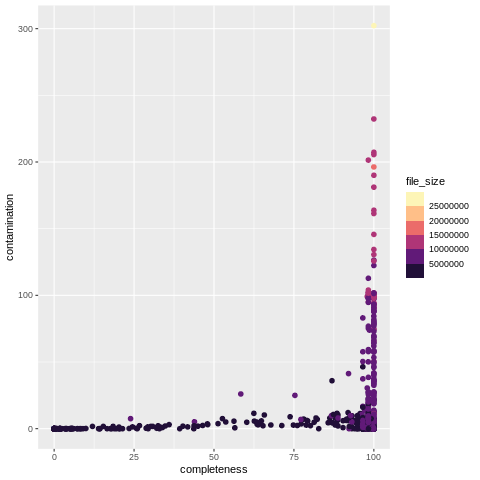

In [147]:
%%R
library(ggplot2)
options(scipen = 999)

p1 <- (
    ggplot(prepped_data, aes(completeness, contamination, colour=file_size)) + 
    geom_point(size=2) +
    scale_colour_viridis_b(option = "A")
)
p1

In [146]:
prepped_data.file_size.describe().apply(lambda x: format(x, 'f'))

count        1533.000000
mean      4951120.801696
std       2331712.143094
min          1449.000000
25%       4037571.000000
50%       5235189.000000
75%       5999149.000000
max      25940253.000000
Name: file_size, dtype: object

Descent genomes are generally between 4 and 6 megabytes. Of course there are exceptions but for checkm  if the file is between those values theres a good chance we'll receive a good quality genome.

### Control Data

In [148]:
query = f"""
    SELECT plate, aim, pass, evaluation_type, kid
            
      FROM microbial_metadata.isolate_assembly_mash_controls
      WHERE run = 171
                        """
control_data = ATHENA_CURSOR.execute(query).as_pandas()

In [150]:
control_data.head()

,plate,aim,pass,evaluation_type,kid
0,1024,48281,True,threshold,95.847570
1,1016,48281,True,threshold,92.982920
2,1010,48415,True,manual,89.769780
3,1019,6590,True,threshold,91.317116
4,1009,14690,True,threshold,99.225880


In [151]:
%Rpush control_data

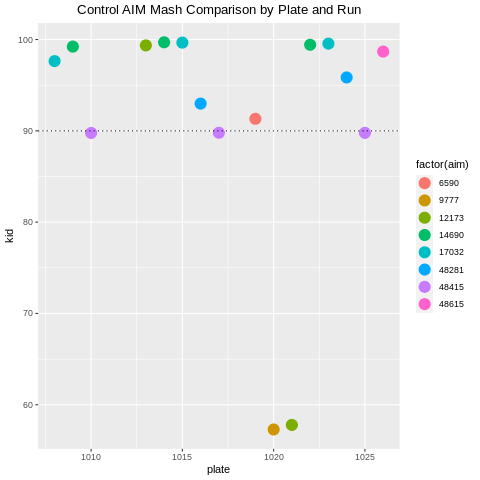

In [154]:
%%R 
p2 <- (
    ggplot(control_data, aes(plate, kid,colour = factor(aim))) + 
    geom_point(size=5) +
    geom_hline(yintercept=90, linetype="dotted", color="black") +
    labs(title="Control AIM Mash Comparison by Plate and Run") +
    theme(plot.title = element_text(hjust = 0.5))
)
p2

### Notes
- There are still 5 plates that need to be processed. 
- Three plates have mislabled controls and I have asked MOgene to update the data. 
- The file sizes of two controls were so small they couldn't be processed. I have notified MOgene to look into the issue.
- 48415 may have drifted from the original reference file. All didn't pass by 1% but they matched many other assemblies from the same AIM
- The 2 controls < 60 were highly contaminated.

In [160]:
(
    aws_qc[[
        'aim', 
        'plate', 
        'completeness', 
        'contamination'
    ]].loc[aws_qc['aim'] > 100000]
    .aim
    .to_csv('../data/run171_aim_list.csv', index=False)
)